# Convolutional Neural Networks Setup

## 1. Packages

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

## 2. Convolutional Layer

### Zero-Padding

- Prevents shrinking the size and volume of image 
- Helps keep information from the image border

`X = (m, n_H, n_W, n_C)`

x.shape =
 (4, 3, 3, 2)
x_pad.shape =
 (4, 7, 7, 2)
x[1,1] =
 [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1] =
 [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


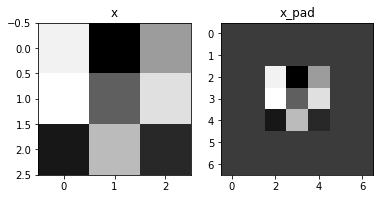

In [2]:
def zero_pad(X, pad):
    X_pad = np.pad(X, ((0, 0), (pad, pad), (pad, pad), (0, 0)), mode='constant', constant_values=(0, 0))
    return X_pad

# FUNCTION ZERO PAD TESTING
np.random.seed(1)
x = np.random.randn(4, 3, 3, 2)
x_pad = zero_pad(x, 2)
print ("x.shape =\n", x.shape)
print ("x_pad.shape =\n", x_pad.shape)
print ("x[1,1] =\n", x[1,1])
print ("x_pad[1,1] =\n", x_pad[1,1])

fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0,:,:,0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0,:,:,0])

### Single Convolution 

Apply one filter defined by parameters W on a single slice (a_slice_prev) of the output activation of the previous layer.

`a_slice_prev = (f, f, n_C_prev)
W = (f, f, n_C_prev)
b = (1, 1, 1)`

In [3]:
def conv_single_step(a_slice_prev, W, b):

    s = a_slice_prev * W
    Z = np.sum(s)
    Z = Z + float(b)

    return Z

# FUNCTION CONVOLUTION SINGLE STEP TESTING
np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

Z = conv_single_step(a_slice_prev, W, b)
print("Z =", Z)

Z = -6.999089450680221


### Forward Pass

`conv_forward` takes filters and convolves them on the input, where each convolution outputs a 2D matrix that will then be stacked to get a 3D volume. 

The formulas relating the output shape of the convolution to the input shape is:
$$ n_H = \lfloor \frac{n_{H_{prev}} - f + 2 \times pad}{stride} \rfloor +1 $$
$$ n_W = \lfloor \frac{n_{W_{prev}} - f + 2 \times pad}{stride} \rfloor +1 $$
$$ n_C = \text{number of filters used in the convolution}$$

In [4]:
def conv_forward(A_prev, W, b, hparameters):
 
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    (f, f, n_C_prev, n_C) = W.shape
    stride = hparameters['stride']
    pad = hparameters['pad']
    
    n_H = int(((n_H_prev - f + 2 * pad) / stride) + 1)     # dimenions of output volume
    n_W = int(((n_W_prev - f + 2 * pad) / stride) + 1)
    Z = np.zeros((m, n_H, n_W, n_C))                       # initialize output Z with zeros
    
    A_prev_pad = zero_pad(A_prev, pad)                     # pad A_prev
    
    for i in range(m):                                     # loop over training examples
        a_prev_pad = A_prev_pad[i]                         # select ith training example's input/previous activation
        
        for h in range(n_H):                               # loop over vertical axis of output
            vert_start = h * stride                        # find vertical start and end of current "slice"
            vert_end = vert_start + f
            
            for w in range(n_W):                           # loop over horizontal axis of output
                horiz_start = w * stride                   # find horizontal start and end of current "slice"
                horiz_end = horiz_start + f                
                
                for c in range(n_C):                       # loop over channels of output ( = # of filters) 
                    a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]     # define slice of input
                    weights = W[:, :, :, c]
                    biases = b[:, :, :, c]
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, weights, biases) # Convolve slice with filter
                                            
    assert(Z.shape == (m, n_H, n_W, n_C))
    cache = (A_prev, W, b, hparameters)             # save cache for back prop
    
    return Z, cache

# FUNCTION FORWARD CONVOLUTION TESTING
np.random.seed(1)
A_prev = np.random.randn(10,5,7,4)
W = np.random.randn(3,3,4,8)
b = np.random.randn(1,1,1,8)
hparameters = {"pad" : 1,
               "stride": 2}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
print("Z's mean =\n", np.mean(Z))
print("Z[3,2,1] =\n", Z[3,2,1])
print("cache_conv[0][1][2][3] =\n", cache_conv[0][1][2][3])

Z's mean =
 0.6923608807576933
Z[3,2,1] =
 [-1.28912231  2.27650251  6.61941931  0.95527176  8.25132576  2.31329639
 13.00689405  2.34576051]
cache_conv[0][1][2][3] =
 [-1.1191154   1.9560789  -0.3264995  -1.34267579]


## 3. Pooling Layer 

This layer reduces the size of the input, reduces the computation, and helps make feature detectors more invariant to its position in the input. It has no parameters, but has the hyperparameter, window size $f$.

- Max-pooling: slides an ($f, f$) window over the input and stores the max value of the window in the output.
- Average-pooling: slides an ($f, f$) window over the input and stores the average value of the window in the output.

### Forward Pooling

Implement MAX-POOL / AVG-POOL. 

In [5]:
def pool_forward(A_prev, hparameters, mode = "max"):
    
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    # define output dimensions & initialize output A
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev
    A = np.zeros((m, n_H, n_W, n_C))
    
    for i in range(m):                           # loop over training examples
        
        for h in range(n_H):                     # loop over vertical axis of output
            vert_start = h * stride
            vert_end = vert_start + f
            
            for w in range(n_W):                 # loop over horizontal axis of output
                horiz_start = w * stride
                horiz_end = horiz_start + f
                
                for c in range (n_C):            # loop over the channels of the output volume
                    
                    # define current slice of A_prev[i]
                    a_prev_slice = A_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] 
                    
                    # compute pooling operation on slice
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_prev_slice)
                    elif mode == "average":
                        A[i, h, w, c] = np.mean(a_prev_slice)
    
    cache = (A_prev, hparameters)                # store input and hparameters in "cache" for pool_backward()
    assert(A.shape == (m, n_H, n_W, n_C))
    
    return A, cache

# FUNCTION POOL FORWARD TESTING

# Case 1: stride of 1
np.random.seed(1)
A_prev = np.random.randn(2, 5, 5, 3)
hparameters = {"stride" : 1, "f": 3}

A, cache = pool_forward(A_prev, hparameters)
print("mode = max")
print("A.shape = " + str(A.shape))
print("A =\n", A)
print()
A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A.shape = " + str(A.shape))
print("A =\n", A)

# Case 2: stride of 2
np.random.seed(1)
A_prev = np.random.randn(2, 5, 5, 3)
hparameters = {"stride" : 2, "f": 3}

A, cache = pool_forward(A_prev, hparameters)
print("mode = max")
print("A.shape = " + str(A.shape))
print("A =\n", A)
print()

A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A.shape = " + str(A.shape))
print("A =\n", A)

mode = max
A.shape = (2, 3, 3, 3)
A =
 [[[[1.74481176 0.90159072 1.65980218]
   [1.74481176 1.46210794 1.65980218]
   [1.74481176 1.6924546  1.65980218]]

  [[1.14472371 0.90159072 2.10025514]
   [1.14472371 0.90159072 1.65980218]
   [1.14472371 1.6924546  1.65980218]]

  [[1.13162939 1.51981682 2.18557541]
   [1.13162939 1.51981682 2.18557541]
   [1.13162939 1.6924546  2.18557541]]]


 [[[1.19891788 0.84616065 0.82797464]
   [0.69803203 0.84616065 1.2245077 ]
   [0.69803203 1.12141771 1.2245077 ]]

  [[1.96710175 0.84616065 1.27375593]
   [1.96710175 0.84616065 1.23616403]
   [1.62765075 1.12141771 1.2245077 ]]

  [[1.96710175 0.86888616 1.27375593]
   [1.96710175 0.86888616 1.23616403]
   [1.62765075 1.12141771 0.79280687]]]]

mode = average
A.shape = (2, 3, 3, 3)
A =
 [[[[-3.01046719e-02 -3.24021315e-03 -3.36298859e-01]
   [ 1.43310483e-01  1.93146751e-01 -4.44905196e-01]
   [ 1.28934436e-01  2.22428468e-01  1.25067597e-01]]

  [[-3.81801899e-01  1.59993515e-02  1.70562706e-01]
   [

## 4. Backpropagation

Calculate derivatives with respect to the cost in order to update the parameters.

### 4.1 - Convoluational Layer Backward Pass 

#### Computing dA:
Formula for computing $dA$ with respect to the cost for a certain filter $W_c$ and a given training example:

$$ dA += \sum _{h=0} ^{n_H} \sum_{w=0} ^{n_W} W_c \times dZ_{hw} \tag{1}$$

```python
da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i, h, w, c]
```

#### Computing dW:
Formula for computing $dW_c$ ($dW_c$ is the derivative of one filter) with respect to the loss:

$$ dW_c  += \sum _{h=0} ^{n_H} \sum_{w=0} ^ {n_W} a_{slice} \times dZ_{hw}  \tag{2}$$

```python
dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
```

#### Computing db:

Formula for computing $db$ with respect to the cost for a certain filter $W_c$:

$$ db = \sum_h \sum_w dZ_{hw} \tag{3}$$

```python
db[:,:,:,c] += dZ[i, h, w, c]
``` 

`dZ = (m, n_H, n_W, n_C)
dA_prev = (m, n_H_prev, n_W_prev, n_C_prev)
dW = (f, f, n_C_prev, n_C)
db = (1, 1, 1, n_C)`

In [6]:
def conv_backward(dZ, cache):
    
    # retrieve information
    (A_prev, W, b, hparameters) = cache
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    (f, f, n_C_prev, n_C) = W.shape
    stride = hparameters['stride']
    pad = hparameters['pad']
    (m, n_H, n_W, n_C) = dZ.shape
    
    # initialize dA_prev, dW, db with the correct shapes
    dA_prev = np.zeros((m, n_H_prev, n_W_prev, n_C_prev))                           
    dW = np.zeros((f, f, n_C_prev, n_C))
    db = np.zeros((1, 1, 1, n_C))

    # pad A_prev and dA_prev
    A_prev_pad = zero_pad(A_prev, pad)
    dA_prev_pad = zero_pad(dA_prev, pad)
    
    for i in range(m):                       # loop over the training examples
        a_prev_pad = A_prev_pad[i]
        da_prev_pad = dA_prev_pad[i]
        
        for h in range(n_H):                   # loop over vertical axis of the output volume
            for w in range(n_W):               # loop over horizontal axis of the output volume
                for c in range(n_C):           # loop over the channels of the output volume
                    
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    
                    # define the slice from a_prev_pad
                    a_slice = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] 

                    # update gradients
                    da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i, h, w, c]
                    dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
                    db[:,:,:,c] += dZ[i, h, w, c]
                    
        # Set the ith training example's dA_prev to unpadded da_prev_pad
        dA_prev[i, :, :, :] = da_prev_pad[pad:-pad, pad:-pad, :]
    
    assert(dA_prev.shape == (m, n_H_prev, n_W_prev, n_C_prev))
    
    return dA_prev, dW, db

# FUNCTION CONV BACKWARD TESTING

np.random.seed(1)
A_prev = np.random.randn(10,4,4,3)
W = np.random.randn(2,2,3,8)
b = np.random.randn(1,1,1,8)
hparameters = {"pad" : 2,
               "stride": 2}
Z, cache_conv = conv_forward(A_prev, W, b, hparameters)

# Test conv_backward
dA, dW, db = conv_backward(Z, cache_conv)
print("dA_mean =", np.mean(dA))
print("dW_mean =", np.mean(dW))
print("db_mean =", np.mean(db))

dA_mean = 1.4524377775388075
dW_mean = 1.7269914583139097
db_mean = 7.839232564616838


### 4.2 Pooling layer - backward pass

Although a pooling layer has no parameters, we still need to backpropagate the gradient through the pooling layer to compute gradients for the layers before it. 

#### Max Pooling  

`create_mask_from_window()` keeps track of where the maximum of the matrix is.

$$ X = \begin{bmatrix}
1 && 3 \\
4 && 2
\end{bmatrix} \quad \rightarrow  \quad M =\begin{bmatrix}
0 && 0 \\
1 && 0
\end{bmatrix}\tag{4}$$

In [7]:
def create_mask_from_window(x):
    mask = x == np.max(x)
    return mask

np.random.seed(1)
x = np.random.randn(2,3)
mask = create_mask_from_window(x)
print('x = ', x)
print("mask = ", mask)

x =  [[ 1.62434536 -0.61175641 -0.52817175]
 [-1.07296862  0.86540763 -2.3015387 ]]
mask =  [[ True False False]
 [False False False]]


#### Average Pooling 

In average pooling, since every element of the input has equal influence on the output, we need to equally distribute value dZ before implementing backprop.

In [8]:
def distribute_value(dz, shape):
    (n_H, n_W) = shape
    average = dz / (n_H * n_W)           # value to distribute on the matrix
    a = np.ones(shape) * average
    return a

a = distribute_value(2, (2,2))
print('distributed value =', a)

distributed value = [[0.5 0.5]
 [0.5 0.5]]


### Pooling Backward 

Implements backward pass of the pooling layer.

If using '`average`', use `distribute_value()` to create a matrix of the same shape as `a_slice`.

If using '`max`', create a mask with `create_mask_from_window()` and multiply it by the corresponding value of dA.

In [9]:
def pool_backward(dA, cache, mode = "max"):
        
    # retrieve information
    (A_prev, hparameters) = cache
    stride = hparameters['stride']
    f = hparameters['f']
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    m, n_H, n_W, n_C = dA.shape
    
    # Initialize dA_prev with zeros (≈1 line)
    dA_prev = np.zeros(A_prev.shape)
    
    for i in range(m):                         # loop over the training examples
        a_prev = A_prev[i]
        
        for h in range(n_H):                   # loop on the vertical axis
            for w in range(n_W):               # loop on the horizontal axis
                for c in range(n_C):           # loop over the channels (depth)
                    
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    
                    # compute backward propagation
                    if mode == "max":
                        a_prev_slice = a_prev[vert_start:vert_end, horiz_start:horiz_end, c]   # define current slice
                        mask = create_mask_from_window(a_prev_slice)                           # create mask from a_prev_slice
                        dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += np.multiply(mask, dA[i, h, w, c])
                    elif mode == "average":
                        da = dA[i, h, w, c]                                                    # get value a from dA
                        shape = (f, f)
                        dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += distribute_value(da, shape)
                        
    assert(dA_prev.shape == A_prev.shape)
    
    return dA_prev

# FUNCTION POOL BACKWARD TESTING

np.random.seed(1)
A_prev = np.random.randn(5, 5, 3, 2)
hparameters = {"stride" : 1, "f": 2}
A, cache = pool_forward(A_prev, hparameters)
dA = np.random.randn(5, 4, 2, 2)

dA_prev = pool_backward(dA, cache, mode = "max")
print("mode = max")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1])  
print()
dA_prev = pool_backward(dA, cache, mode = "average")
print("mode = average")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1]) 

mode = max
mean of dA =  0.14571390272918056
dA_prev[1,1] =  [[ 0.          0.        ]
 [ 5.05844394 -1.68282702]
 [ 0.          0.        ]]

mode = average
mean of dA =  0.14571390272918056
dA_prev[1,1] =  [[ 0.08485462  0.2787552 ]
 [ 1.26461098 -0.25749373]
 [ 1.17975636 -0.53624893]]
